The purpose of this notebook is to show how to train adapter
models to transform query embeddings based on user feedback.

In this notebook, both queries and feedbacks are generated with the an LLM model. So, this is for demonstration purposes. You may obtain better fitted adapter model with actual user feedback and more powerful models.

You will train a simple adapter model, transform model genenerated queires and see if you can get same, worse or better documents retrieved with the query and the adapted query.

Most importantly, you can see that -ve labels are moved in the nagative direction of cosine similarity and +ve labels in the positive direction.

This notebook is adapted from:
https://learn.deeplearning.ai/advanced-retrieval-for-ai/lesson/6/embedding-adaptors

Noteboos is created on google

In [ ]:
!pip install --upgrade --quiet pypdf python-dotenv umap-learn chromadb \
    langchain huggingface_hub sentence-transformers

In [86]:
import os
from dotenv import load_dotenv, find_dotenv
from huggingface_hub import login
_ = load_dotenv(find_dotenv()) # read local .env file
hugging_face_access_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hugging_face_access_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from embedding_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf',
    collection_name='microsoft_annual_report_2022',
    embedding_function=embedding_function)

chroma_collection.count()

In [ ]:
import numpy as np
from tqdm import tqdm
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [ ]:
# https://pypi.org/project/umap-learn/
import umap
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [05:56<00:00,  1.02s/it]


In [247]:
from dataclasses import dataclass

@dataclass
class PlotLayer:
    embedding: list
    size: int = None
    color: str = None
    facecolor: str = None
    edgecolor: str = None
    marker: str = None
    label: str = None

import matplotlib.pyplot as plt
%matplotlib inline

def plot_projections(title, PlotLayers: list[PlotLayer], legend: list[str] = []) -> None:
    plt.figure()
    for PlotLayer in PlotLayers:
        plt.scatter(PlotLayer.embedding[:, 0], PlotLayer.embedding[:, 1],
            s=PlotLayer.size, marker=PlotLayer.marker, color=PlotLayer.color,
            facecolor = PlotLayer.facecolor, edgecolor=PlotLayer.edgecolor)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.axis('off')
    if len(legend) > 0:
        plt.legend(legend)
    plt.show()

In [ ]:
# Exapnsion with generated queries
import llm_utils
llm = llm_utils.HuggingFaceHub(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

chat_model = llm_utils.ChatHuggingFace(llm=llm)

                    repo_id was transferred to model_kwargs.
                    Please confirm that repo_id is what you intended.
                    task was transferred to model_kwargs.
                    Please confirm that task is what you intended.
                    huggingfacehub_api_token was transferred to model_kwargs.
                    Please confirm that huggingfacehub_api_token is what you intended.


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate
def generate_queries(chat_model):

    system_message = """
        You are a helpful expert financial research assistant.
        You help users analyze financial statements to better
        understand companies. Suggest 10 to 15 short questions that
        are important to ask when analyzing an annual report.
        Do not output any compound questions
        (questions with multiple sentences or conjunctions).
        Output each question on a separate line divided by a newline.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content="Follow instructions when generating queries"

      ),
    ]

    response = chat_model.invoke(messages)

    return response.content.split("\n")

In [91]:
generated_queries = generate_queries(chat_model=chat_model)
for query in generated_queries:
    print(query)

1. What is the company's revenue for the past year?
2. How does this year's revenue compare to the previous year's revenue?
3. What is the company's net income for the past year?
4. How does this year's net income compare to the previous year's net income?
5. What is the company's gross profit margin?
6. Has the gross profit margin increased, decreased, or remained the same from the previous year?
7. What is the company's current ratio?
8. Does the current ratio indicate that the company has enough assets to cover its short-term liabilities?
9. What is the company's debt-to-equity ratio?
10. Is the debt-to-equity ratio higher or lower than the industry average?
11. What is the company's return on equity (ROE)?
12. Has the ROE increased, decreased, or remained the same from the previous year?
13. What is the company's earnings per share (EPS)?
14. How does this year's EPS compare to the previous year's EPS?
15. What is the company's dividend policy?
16. Has the dividend per share increa

In [92]:
import copy
from random import sample
all_queries = copy.deepcopy(generated_queries)#these doesn't work. Try deep copy
print(len(all_queries))

28


In [159]:
generated_queries  = sample(all_queries, 16)
generated_queries = [q for q in generated_queries if len(q.strip()) > 10]
print(len(generated_queries))
for query in generated_queries:
    print(query)

16
19. What is the company's inventory turnover ratio?
26. Has the fixed asset turnover ratio increased, decreased, or remained the same from the previous year?
3. What is the company's net income for the past year?
2. How does this year's revenue compare to the previous year's revenue?
11. What is the company's return on equity (ROE)?
21. What is the company's accounts receivable turnover ratio?
25. What is the company's fixed asset turnover ratio?
20. Has the inventory turnover ratio increased, decreased, or remained the same from the previous year?
9. What is the company's debt-to-equity ratio?
14. How does this year's EPS compare to the previous year's EPS?
23. What is the company's accounts payable turnover ratio?
8. Does the current ratio indicate that the company has enough assets to cover its short-term liabilities?
10. Is the debt-to-equity ratio higher or lower than the industry average?
5. What is the company's gross profit margin?
16. Has the dividend per share increased, d

In [160]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10,
                                  include=['documents', 'embeddings'])
retrieved_documents = results['documents']
print(len(retrieved_documents) * len(retrieved_documents[0]))

retrieved_embeddings = results['embeddings']

# generated query embeddings
query_embeddings = embedding_function(generated_queries)
len(query_embeddings)

160


16

In [ ]:
def evaluate_results(query, statement, chat_model):

    system_message = """
        You are a helpful expert financial research assistant.
        You help users analyze financial statements
        to better understand companies.
        For the given query, evaluate whether the following satement is relevant.
        Answer yes or no.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content=f"Query: {query}, Statement: {statement}"

      ),
    ]

    response = chat_model.invoke(messages)
    content = response.content
    if len(content.strip()) > 0:
        print(content)
        print("\n")
        if 'yes' in content or 'relevant' in content or "Yes" in content or "Relevant" in content:
            return 1
        return -1
    return 0


In [161]:
adapter_query_embeddings = [] # for query embeddings
adapter_doc_embeddings = [] # for result embeddings
adapter_labels = [] # for generated labels

In [ ]:
# q and d are used as list indices
# query and document are texts that are evaluated
# label is the result of query and document evaluation

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        if len(document.strip()) != 0:
            label = evaluate_results(query, document, chat_model)
            if label == 1 or label == -1:
                adapter_query_embeddings.append(query_embeddings[q])
                adapter_doc_embeddings.append(retrieved_embeddings[q][d])
                adapter_labels.append(label)

In [163]:
len(adapter_labels), len(adapter_query_embeddings), len(adapter_doc_embeddings)


(160, 160, 160)

In [164]:
import torch

adapter_query_embeddings = torch.Tensor(adapter_query_embeddings)
adapter_doc_embeddings = torch.Tensor(adapter_doc_embeddings)
adapter_labels = torch.Tensor(adapter_labels)
adapter_labels = adapter_labels.reshape(adapter_labels.shape[0],)
print(adapter_query_embeddings.shape, adapter_doc_embeddings.shape, adapter_labels.shape)
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

torch.Size([160, 384]) torch.Size([160, 384]) torch.Size([160])


In [186]:
import torch
class AdapterModel(torch.nn.Module):
    def __init__(self, adpater_matrix_shape):
        super().__init__()
        self.adapter_matrix = torch.nn.Parameter(
            torch.zeros(adpater_matrix_shape),
            requires_grad=True)

        # try different initializaiton methods
        torch.nn.init.xavier_uniform_(self.adapter_matrix)

    def forward(self, input):
        #self.adapter_matrix = self.adapter_matrix.relu()

        output = self.adapter_matrix @ input.t()
        return output.t()

In [166]:
def get_model():
    model = AdapterModel((384, 384))
    return model

In [167]:
model = get_model()
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([384, 384])
Parameter containing:
tensor([[-0.0125,  0.0376, -0.0384,  ...,  0.0231,  0.0321, -0.0120],
        [ 0.0445,  0.0862,  0.0292,  ..., -0.0457,  0.0409,  0.0354],
        [ 0.0014,  0.0680, -0.0035,  ..., -0.0865, -0.0581,  0.0707],
        ...,
        [-0.0314, -0.0394, -0.0080,  ...,  0.0045, -0.0664, -0.0455],
        [-0.0592,  0.0275, -0.0607,  ..., -0.0614, -0.0245,  0.0098],
        [ 0.0782,  0.0107, -0.0283,  ..., -0.0183,  0.0560, -0.0118]],
       requires_grad=True)


In [188]:
model = get_model()
test_vector = torch.ones([3, 384])
test_vector.shape
result = model(test_vector)
result.shape

torch.Size([3, 384])

In [235]:
# define train function
def train(model, optimizer, loss_func, epochs=150):
    for epoch in tqdm(range(epochs)):
        for query_embedding, document_embedding, label in dataset:
            updated_query_embedding = model(query_embedding)
            cosine_similarity = F.cosine_similarity(updated_query_embedding, document_embedding, dim=0)
            loss = loss_func(cosine_similarity, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print("\n")
    print(f"loss = {loss.detach().numpy()}")


In [236]:
model = get_model()

import torch.nn.functional as F
# create a loss function
def loss_function(cosine_similarity, label):
    return F.mse_loss(cosine_similarity, label)

# crete an optimizer
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.01)
#train
train(model=model, optimizer=optimizer, loss_func=loss_function)

100%|██████████| 150/150 [00:40<00:00,  3.68it/s]



loss = 0.42067328095436096


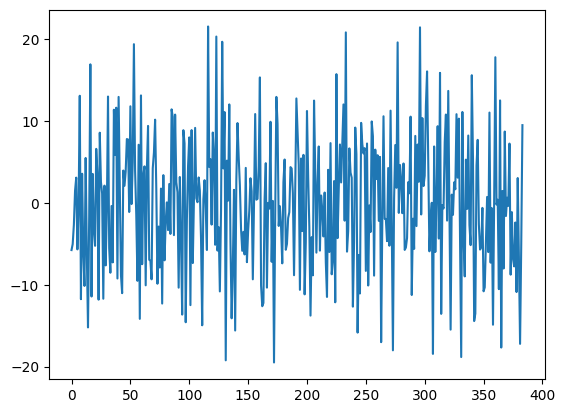

In [237]:
# The transformation of a unit vector by the leaned adapter matrix.
# Some of the dimenstion are stretched in the positive and some
# in the opposite dimensions. Some are shrinked to 0

model.eval()
with torch.no_grad():
    scaled_vector = model(test_vector[0])

plt.plot(scaled_vector.numpy())
plt.show()

In [238]:
query_embeddings = embedding_function(generated_queries)
input_query_embeddings = torch.Tensor(query_embeddings)
with torch.no_grad():
    adapted_query_embeddings = model(input_query_embeddings).numpy()

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


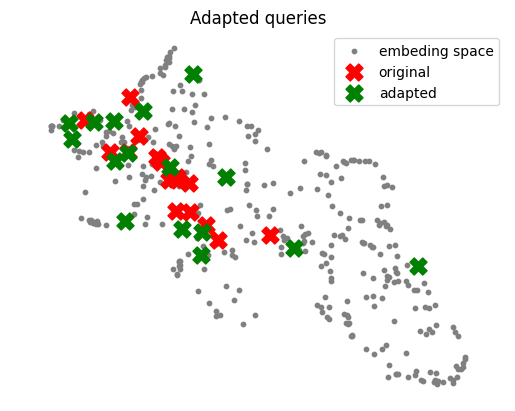

In [248]:
# Plot the projected query and retrieved documents in the embedding space
# Notice how queries are now appearing
layers = [PlotLayer(projected_dataset_embeddings, size=10, color='gray', label="embeding space"),
               PlotLayer(projected_query_embeddings, size=150, marker='X', color='r', label="original"),
               PlotLayer(projected_adapted_query_embeddings, size=150, marker='X', color='green', label="adapted" )]
plot_projections("Adapted queries", layers, ["embeding space", "original", "adapted"])

In [240]:
label_index = 0

for i in range(len(query_embeddings)):
  print("label       orignial similarity   adapted similarity")
  print("-"*60)
  for j in range(len(retrieved_embeddings[i])):

      label = adapter_labels[label_index]

      old_query_embedding = torch.tensor(query_embeddings[i])
      adapted_query = torch.tensor(adapted_query_embeddings[i])

      sim0 = torch.cosine_similarity(old_query_embedding, adapted_query, dim=0).numpy()

      document_embedding = torch.tensor(np.array(retrieved_embeddings[i][j]))

      sim1 = torch.cosine_similarity(old_query_embedding, document_embedding, dim=0).numpy()
      sim2 = torch.cosine_similarity(adapted_query, document_embedding, dim=0).numpy()

      print(label, sim1, sim2)

      label_index += 1

      print("-"*60)


label       orignial similarity   adapted similarity
------------------------------------------------------------
tensor(1.) 0.4979718466315829 0.7184716292408113
------------------------------------------------------------
tensor(1.) 0.4897288836395354 0.625468058345713
------------------------------------------------------------
tensor(1.) 0.48202951644277325 0.6714815750322616
------------------------------------------------------------
tensor(1.) 0.47409518150407814 0.7789529419494369
------------------------------------------------------------
tensor(1.) 0.4643656338652529 0.6096710292508007
------------------------------------------------------------
tensor(1.) 0.44965198257818406 0.7201301979476931
------------------------------------------------------------
tensor(-1.) 0.4420814227977097 0.10521455204288072
------------------------------------------------------------
tensor(1.) 0.44142222680057785 0.7042269164182532
------------------------------------------------------------
t

In [245]:
index = 2
print(word_wrap(generated_queries[index]))
print("")
qe = query_embeddings[index]
results = chroma_collection.query(query_embeddings=qe, n_results=5,
                                  include=['documents', 'embeddings'])
docs = results["documents"]
for d in docs:
    print(word_wrap(d[0]))

3. What is the company's net income for the past year?

37 general and administrative expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with finance, legal, facilities, certain
human resources and other administrative personnel, certain taxes, and
legal and other administrative fees. general and administrative
expenses increased $ 793 million or 16 % driven by investments in
corporate functions. other income ( expense ), net the components of
other income ( expense ), net were as follows : ( in millions ) year
ended june 30, 2022 2021 interest and dividends income $ 2, 094 $ 2,
131 interest expense ( 2, 063 ) ( 2, 346 ) net recognized gains on
investments 461 1, 232 net gains ( losses ) on derivatives ( 52 ) 17
net gains ( losses ) on foreign currency remeasurements ( 75 ) 54
other, net ( 32 ) 98 total $ 333 $ 1, 186


In [246]:
print(word_wrap(generated_queries[index]))
print("")
aqe = adapted_query_embeddings[index].tolist()
results = chroma_collection.query(query_embeddings=aqe, n_results=5,
                                  include=['documents', 'embeddings'])
docs = results["documents"]
for d in docs:
    print(word_wrap(d[0]))

3. What is the company's net income for the past year?

48 comprehensive income statements ( in millions ) year ended june 30,
2022 2021 2020 net income $ 72, 738 $ 61, 271 $ 44, 281 other
comprehensive income ( loss ), net of tax : net change related to
derivatives 6 19 ( 38 ) net change related to investments ( 5, 360 ) (
2, 266 ) 3, 990 translation adjustments and other ( 1, 146 ) 873 ( 426
) other comprehensive income ( loss ) ( 6, 500 ) ( 1, 374 ) 3, 526
comprehensive income $ 66, 238 $ 59, 897 $ 47, 807 refer to
accompanying notes.
